Epoch 1/5: 100%|██████████| 8973/8973 [16:02<00:00,  9.32it/s]



Epoch 1/5 Summary:
Train Loss: 7.2775 | Val Loss: 7.1533
ROUGE Scores: 0.0037/0.0000/0.0037
Learning Rate: 2.00e-04 | TF Ratio: 0.90


Epoch 2/5: 100%|██████████| 8973/8973 [16:20<00:00,  9.15it/s]



Epoch 2/5 Summary:
Train Loss: 7.1765 | Val Loss: 7.1625
ROUGE Scores: 0.0398/0.0000/0.0398
Learning Rate: 2.00e-04 | TF Ratio: 0.90


Epoch 3/5: 100%|██████████| 8973/8973 [24:15<00:00,  6.16it/s]



Epoch 3/5 Summary:
Train Loss: 7.1613 | Val Loss: 7.2087
ROUGE Scores: 0.0696/0.0000/0.0615
Learning Rate: 2.00e-04 | TF Ratio: 0.63


Epoch 4/5: 100%|██████████| 8973/8973 [41:23<00:00,  3.61it/s] 



Epoch 4/5 Summary:
Train Loss: 7.1367 | Val Loss: 7.2311
ROUGE Scores: 0.0398/0.0000/0.0398
Learning Rate: 2.00e-04 | TF Ratio: 0.37


Epoch 5/5: 100%|██████████| 8973/8973 [59:55<00:00,  2.50it/s]  



Epoch 5/5 Summary:
Train Loss: 6.9454 | Val Loss: 7.1638
ROUGE Scores: 0.0696/0.0000/0.0615
Learning Rate: 2.00e-04 | TF Ratio: 0.10
Saved training dynamics plot to ./weight_tying_training_dynamics


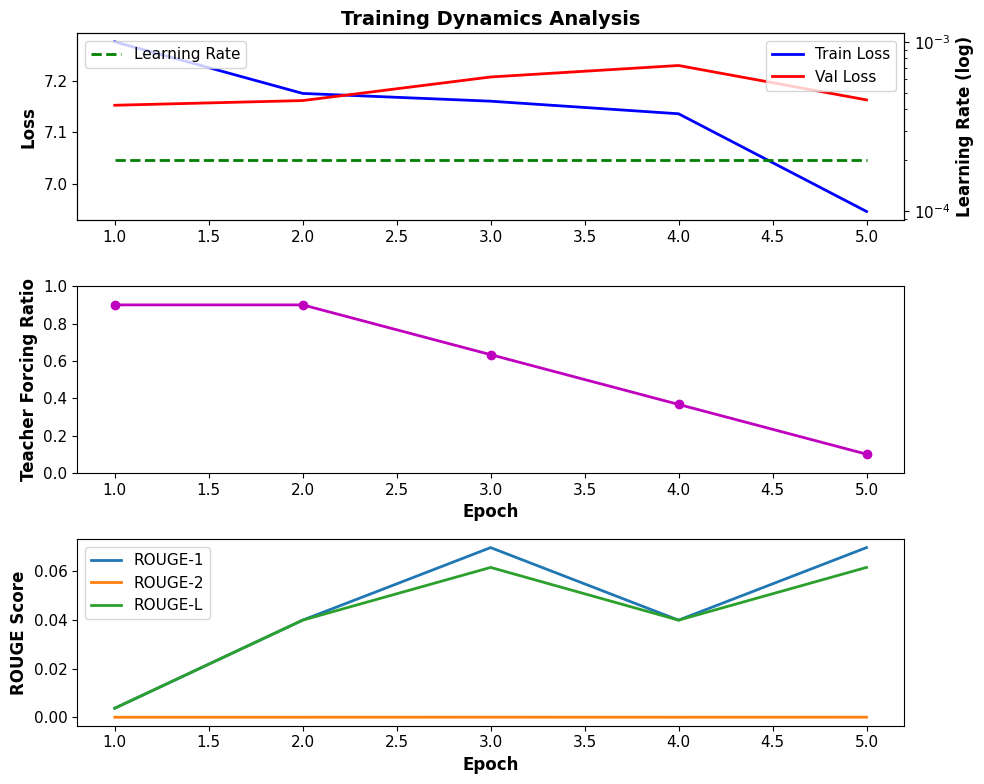

In [8]:
import torch
import torch.nn as nn
from data_utils import get_train_loader, get_val_loader, get_test_loader, set_seed
from weight_tying_transformer_model import create_small_weight_tied_transformer
from modeling_functions import train_transformer_teacher_forcing
from optimizer_scheduler import get_optimizer, get_plateau_scheduler, linear_teacher_scheduler
from tokenizers import Tokenizer
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
import visualization

def compute_rouge_score(preds, targets, tokenizer):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    for p, t in zip(preds, targets):
        pred_text = tokenizer.decode(p.tolist(), skip_special_tokens=True)
        target_text = tokenizer.decode(t.tolist(), skip_special_tokens=True)
        score = scorer.score(target_text, pred_text)
        for k in scores:
            scores[k] += score[k].fmeasure
    for k in scores:
        scores[k] /= len(preds)
    return scores

if __name__ == "__main__":
    torch.cuda.empty_cache()
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    config = {
        "vocab_size": 20000,
        "dropout": 0.1,
        "d_model": 384,
        "nhead": 6,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 1536
    }

    tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
    pad_idx = tokenizer.token_to_id("[PAD]")

    model = create_small_weight_tied_transformer(**config).to(device)
    optimizer = get_optimizer(model)
    plateau_scheduler = get_plateau_scheduler(optimizer)
    teacher_scheduler = linear_teacher_scheduler
    criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

    train_loader = get_train_loader(tokenizer, batch_size=32, num_workers=2)
    val_loader = get_val_loader(tokenizer, batch_size=4, num_workers=0)
    test_loader = get_test_loader(tokenizer, batch_size=4, num_workers=0)

    history = train_transformer_teacher_forcing(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        plateau_scheduler=plateau_scheduler,
        teacher_forcing_scheduler=teacher_scheduler,
        criterion=criterion,
        device=device,
        num_epochs=5,
        filename="weighy_tying_model.pt",
        tokenizer=tokenizer,
        pad_idx=pad_idx
    )

    visualization.visualize_training_dynamics(history, "./weight_tying_training_dynamics")
    